In [41]:
import mne
mne.__version__

'0.22.0'

In [42]:
eeg_raw = mne.io.read_raw_bdf("/Users/reallo/Downloads/eeg-test/sub-001/sess/eeg/sub-001_task-P300_run-01_eeg.bdf",preload=True)
eeg_raw.info

Extracting EDF parameters from /Users/reallo/Downloads/eeg-test/sub-001/sess/eeg/sub-001_task-P300_run-01_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 194047  =      0.000 ...   757.996 secs...


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 79 EEG, 1 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 52.0 Hz
 meas_date: 2011-08-12 15:47:56 UTC
 nchan: 80
 projs: []
 sfreq: 256.0 Hz
>

In [99]:
eeg_raw = mne.io.read_raw_fif("/Volumes/R/MEG/MEG2224_li_yi_20170302_EP_4_tsss.fif",preload=True)

Opening raw data file /Volumes/R/MEG/MEG2224_li_yi_20170302_EP_4_tsss.fif...
    Range : 17000 ... 496999 =     17.000 ...   496.999 secs
Ready.
Reading 0 ... 479999  =      0.000 ...   479.999 secs...


<ipython-input-99-7ffadb375029>:1: RuntimeWarning: This filename (/Volumes/R/MEG/MEG2224_li_yi_20170302_EP_4_tsss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  eeg_raw = mne.io.read_raw_fif("/Volumes/R/MEG/MEG2224_li_yi_20170302_EP_4_tsss.fif",preload=True)


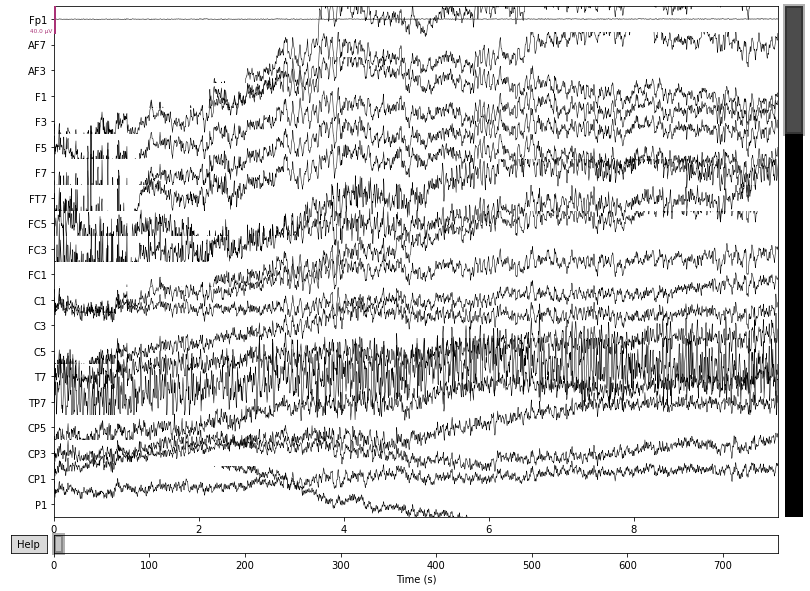

In [3]:
eeg_raw.plot();

In [220]:
picks = mne.pick_types(eeg_raw.info,eeg=True,selection=['Oz'])
picks

array([28])

In [91]:
# l_freq and h_freq are the frequencies below which and above which, respectively, to filter out of the data. Thus the uses are:

# l_freq < h_freq: band-pass filter
# l_freq > h_freq: band-stop filter
# l_freq is not None and h_freq is None: high-pass filter
# l_freq is None and h_freq is not None: low-pass filter

high_pass = 1
low_pass = 0.1
# eeg_raw.filter(l_freq=low_pass,h_freq=high_pass,picks=picks)
eeg_raw.filter(l_freq=low_pass,h_freq=high_pass)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 33001 samples (33.001 sec)



<Raw | MEG2224_li_yi_20170302_EP_4_tsss.fif, 311 x 480000 (480.0 s), ~1.12 GB, data loaded>

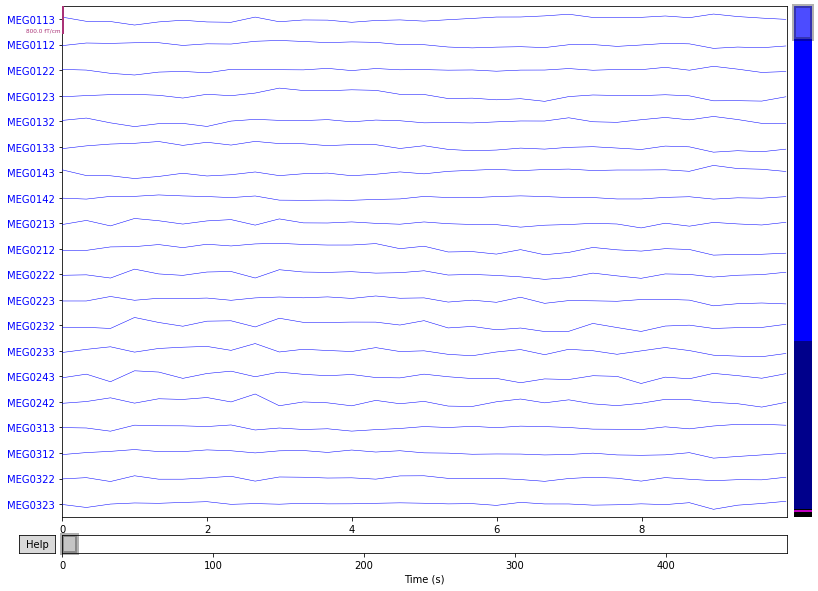

In [92]:
eeg_raw.plot();

<Raw | MEG2224_li_yi_20170302_EP_4_tsss.fif, 1 x 50001 (50.0 s), ~5.4 MB, data loaded>
tf_data: (1, 1, 50001)


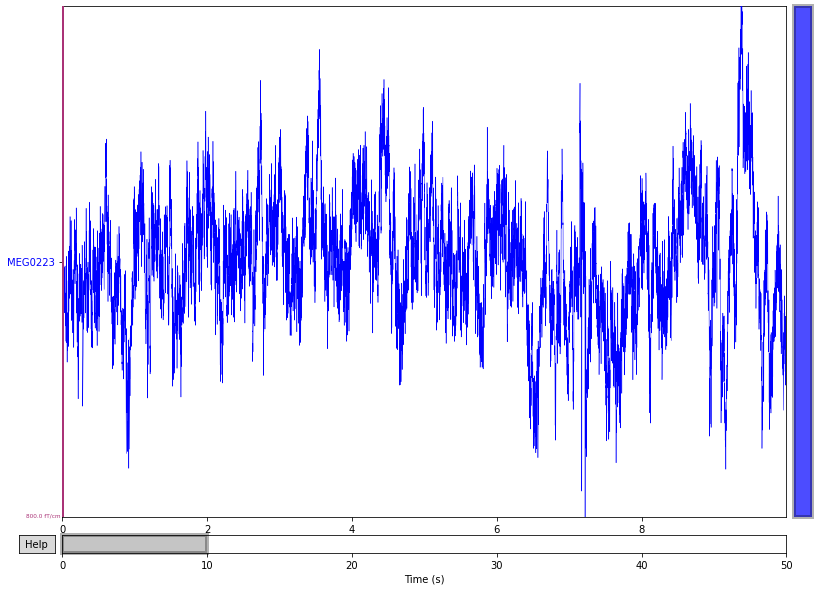

Effective window size : 2.048 (s)
Need more than one channel to make topography for grad. Disabling interactivity.


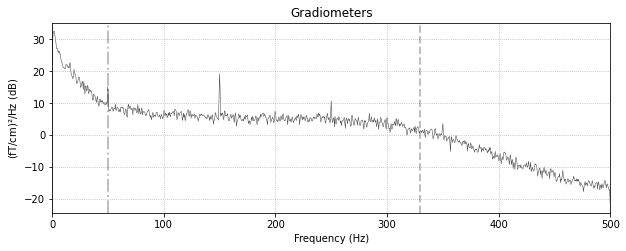

In [100]:
import numpy as np
from mne.baseline import rescale
from matplotlib import pyplot as plt
from mne.time_frequency import tfr_morlet,tfr_array_morlet

data = eeg_raw.copy().crop(60,110) # select by second
data.pick_channels(['MEG0223'])
print(data)
# expand dims
tf_data = data.get_data()
tf_datas = np.expand_dims(tf_data,axis=0) #(1,1,301)
print("tf_data:",tf_datas.shape)
data.plot();
data.plot_psd();

high freqs: 380.0
Applying baseline correction (mode: mean)
power shape: (1, 200, 50001)
power min: -6.713655094461012e-21
power max: 2.0110902342572643e-19


<ipython-input-103-c09bf91b21e5>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(data.times, freqs, power[0],


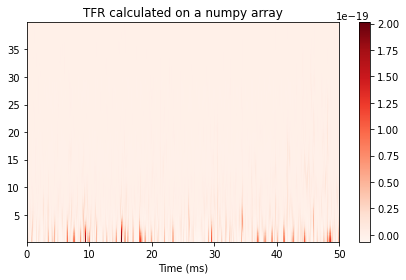

In [103]:
# define frequencies of interest
freqs = np.arange(0.1,40, 0.2)
# freqs = [1,2,3]
freqs = np.logspace(*np.log10([0.1, 35]), num=round(35/2))
vmin,vmax = 0.,3. # Define our color limits.
# different number of cycle per frequency
n_cycles = freqs/2.
# print("freqs:",freqs)
print("high freqs:",eeg_raw.info['sfreq']/2-120)
power = tfr_array_morlet(tf_datas, sfreq=eeg_raw.info['sfreq'],
                         freqs=freqs, n_cycles=n_cycles,use_fft=True,
                         output='avg_power')


# Baseline the output
rescale(power, tf_datas.shape[2], (0.,tf_datas.shape[2] ), mode='logratio', copy=False)
print("power shape:",power.shape)
print("power min:",np.min(power[0]))
print("power max:",np.max(power[0]))

# if np.max(power[0]) > vmax:
#     vmax = np.max(power[0])

fig, ax = plt.subplots()
mesh = ax.pcolormesh(data.times, freqs, power[0],
                     cmap='Reds', vmin=np.min(power[0]), vmax=np.max(power[0])) #RdBu_r
ax.set_title('TFR calculated on a numpy array')
ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
fig.colorbar(mesh)
plt.tight_layout()
plt.show()

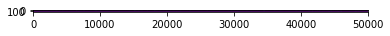

In [106]:
plt.imshow(power[0]);

In [15]:
tf_datas[0,:].shape

(1, 257)

(5121,)
wcf 0.7
cparam 28.0
scales [ 1.4         1.47368421  1.55555556  1.64705882  1.75        1.86666667
  2.          2.15384615  2.33333333  2.54545455  2.8         3.11111111
  3.5         4.          4.66666667  5.6         7.          9.33333333
 14.        ]
cwtmatr: (19, 1, 5121)
frequencies: [128.  121.6 115.2 108.8 102.4  96.   89.6  83.2  76.8  70.4  64.   57.6
  51.2  44.8  38.4  32.   25.6  19.2  12.8]


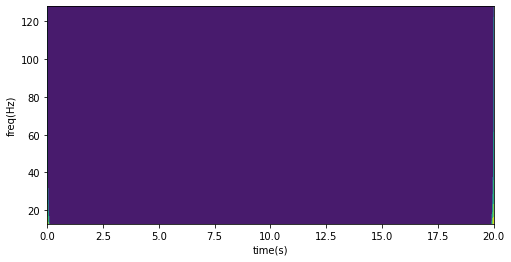

In [40]:
import pywt

def TimeFrequencyCWT(data,fs,totalscal,wavelet='cgau8'):
    # 采样数据的时间维度
    t = np.arange(data.shape[1])/fs
    print(t.shape)
    # 中心频率
    wcf = pywt.central_frequency(wavelet=wavelet)
    print("wcf",wcf)
    # 计算对应频率的小波尺度
    cparam = 2 * wcf * totalscal
    print("cparam",cparam)
    scales = cparam/np.arange(totalscal, 1, -1)
    print("scales",scales)
    # 连续小波变换
    [cwtmatr, frequencies] = pywt.cwt(data, scales, wavelet, 1.0/fs)
    print("cwtmatr:",cwtmatr.shape)
    print("frequencies:",frequencies)
    
    # 绘图
    plt.figure(figsize=(8, 4))
    
    plt.contourf(t, frequencies, abs(cwtmatr[:,0,:]))
    plt.ylabel(u"freq(Hz)")
    plt.xlabel(u"time(s)")
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    
TimeFrequencyCWT(tf_datas[0,:],fs=eeg_raw.info['sfreq'],totalscal=20);
